In [ ]:
using Pkg
Pkg.add("StatsPlots")
Pkg.add("GraphRecipes")
Pkg.add("Gadfly")
Pkg.add("Conda")
Pkg.add("Random")
Pkg.add("DataTables")
Pkg.add("TypedTables")
Pkg.add("MacroTools")
Pkg.add("TexTables")
Pkg.add("PlotlyJS")
Pkg.add("Images")
Pkg.add("FileIO")
Pkg.add("ClinicalTrialUtilities")
Pkg.add("KernelDensity")
Conda.pip_interop(true)
Conda.pip("install", "webio_jupyter_extension")

In [1]:
using Pkg
using Random
using GLM, StatsModels
using DataTables
using DelimitedFiles, DataFrames, Lasso
using FilePaths
using StatsModels, Combinatorics
using CategoricalArrays
using StatsBase, Statistics
using TypedTables
using MacroTools
using NamedArrays
using PrettyTables # Dataframe or Datatable to latex
using TexTables # pretty regression table and tex outcome
using Plots
using Conda
using Images, FileIO
using ClinicalTrialUtilities
using PlotlyJS
using Gadfly
using KernelDensity

## 1. Multicollinearity

Multicollinearity refers to the situation in which, under a econometric model, there are two or more regressors (also called independent variables) that are correlated in some degree. Usually, in the literature, this problem is separated in:

+ **Perfect multicollinearity:** a problem that implies the matrix (X'X) not being invertible, as it does not have complete rank anymore. This problem arises when at least one regressor is a linear combination of other regressor(s).

+ **Imperfect multicollinearity:** appears when there is a high correlation, altough not perfectly linear, between regressors. The OLS method can still be applied, and the coefficients can be calculated. Nevertheless, the variance of these estimators will increase as the correlation increases, leading to lower t-statistics, and hence a higher probability of not rejecting the null hypothesis H0, even though the variable could be relevant.

To see this, consider the following model:

$$Y_i = \beta_1 + \beta_2 W_{2i} + ... + \beta_{k-1}W_{(k-1)i} + \beta_z Z_i + \mu_i$$

Where the correlation between Z and variables W is high. We want to prove that the variance of the estimator $\beta_z$ increases as the correlation between the W's and Z increases. Let us put the presented model in matrix form, as:

$$y =  W\beta + Z \beta_z + \mu$$

Where W is the matrix of variables $W_j$ and the column of 1's. Z is the column vector of variables $Z_i$. Applying the Frisch-Waugh Theorem and partial regressions, we know that:

$$ \widehat{\beta_z} = (Z'M_w Z)^{-1}Z' M_w y$$

Where $M_w = I - W(W'W)^{-1}W'$, then:

$$\widehat{\beta_z} = (Z'M_w Z)^{-1}Z' M_w ( W\beta + Z \beta_z + \mu) = \beta_z + (Z'M_w Z)^{-1}Z' M_w \mu$$

Therefore, $E(\widehat{\beta_z}) = \beta_z$ the estimator is unbiased. It follows from that:

$$var(\widehat{\beta_z}) = E\left[(\widehat{\beta_z}-\beta_z)(\widehat{\beta_z}-\beta_z)'\right]$$

$$var(\widehat{\beta_z}) = E\left[((Z'M_w Z)^{-1}Z' M_w \mu)(\mu 'M_w^{'}Z(Z'M_w Z)^{-1} )\right]$$

$$var(\widehat{\beta_z}) = E\left[(Z'M_w Z)^{-1}Z' M_w \mu \mu 'M_w^{'}Z(Z'M_w Z)^{-1}\right] $$

$$var(\widehat{\beta_z}) = \sigma^2 (Z'M_w Z)^{-1} = \frac{\sigma^2}{Z'M_w Z} = \frac{\sigma^2}{Z'M_w^{'}M_w Z} = \frac{\sigma^2}{e_z^{'} e_z} $$

Recall that $M_w Z$ is the vector of residuals from the regression of Z on the variables $W_j$. This latter regression yields a $R^2$:

$$R^2_z = 1- \frac{e_z^{'} e_z}{\sum_{i=1}^n (Z_i-\bar{Z})^2}$$

Replacing $e_z^{'} e_z$ as a function of $R^2$ in the equation of the variance:

$$var(\widehat{\beta_z}) = \frac{\sigma^2}{(1-R^2_z)\sum_{i=1}^n (Z_i-\bar{Z})^2}$$

While the correlation between Z and $W_j$ increases (which implies $R^2_z \rightarrow 1$), then $var(\widehat{\beta_z}) \rightarrow \infty$.

In [2]:
m=10
n=10
A=zeros(m,n)

for i in 1:(n-1)
    temp = randn(10)
    A[:,i] = temp
end

In [3]:
#The last column is a linear combination of three vectors (from A)
A[:,10] = 0.5*A[:,1]+ 0.5*A[:,2]
A

10×10 Matrix{Float64}:
  0.501424   2.33014   -0.588513   …   0.33932      0.902817   1.41578
  0.229565   0.496142  -0.690482      -0.199448     0.577443   0.362853
  1.26491   -0.489678   0.524373      -1.04054     -0.394571   0.387618
  1.34268   -0.370234  -0.640244       0.403512     1.00102    0.486222
  0.123511  -1.46896   -0.480382       1.15467      2.86276   -0.672722
 -1.56356    0.795115   0.49276    …  -0.0550964   -0.155911  -0.384221
  0.123536  -0.900076  -0.157412      -2.90485     -0.761958  -0.38827
  1.31983    2.5552     0.0759475      0.126657     1.24901    1.93751
 -0.627868  -1.21785   -1.73209        0.312876    -1.42755   -0.922859
  0.28068    1.09421   -0.58454        0.00273404   0.865664   0.687444

In [4]:
#We should not be able to invert this matrix
inv(A)

10×10 Matrix{Float64}:
  1.82653e15  -8.66904e14   1.53059e15  …   6.06548e14  -2.71182e14
  1.82653e15  -8.66904e14   1.53059e15      6.06548e14  -2.71182e14
 -0.322614     0.2241      -0.032776       -0.475945    -0.107604
  3.41651     -0.796798     0.219773       -1.14961      0.530822
 -0.292802     0.200186     0.111385        0.174155    -0.270638
 -0.340136    -0.110503     0.251844    …   0.259735     0.0304348
 -1.02324      0.378217     0.11807         0.335001    -0.011283
 -1.22617      0.3783       0.0198841       0.551687    -0.560248
  1.25823     -0.359622    -0.0415768      -0.580098     0.402005
 -3.65306e15   1.73381e15  -3.06118e15     -1.2131e15    5.42363e14

**Nevertheless, we get a result :(** This may be due to the limited precision of decimals of Julia. Note that we get gigantic-numeric values for some numbers in the inverse of A.

## Analyzing RCT data with Precision Adjustment

In [5]:
mat, head = readdlm("GitHub/ECO224/data/penn_jae.dat", header=true, Float64)
mat
df =DataFrame(mat, vec(head))
describe(df)

23×7 DataFrame
 Row │ variable    mean            min      median   max      nmissing  eltype ⋯
     │ Symbol      Float64         Float64  Float64  Float64  Int64     DataTy ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ abdt        10693.6         10404.0  10691.0  10880.0         0  Float6 ⋯
   2 │ tg              2.56889         0.0      2.0      6.0         0  Float6
   3 │ inuidur1       12.9148          1.0     10.0     52.0         0  Float6
   4 │ inuidur2       12.1938          0.0      9.0     52.0         0  Float6
   5 │ female          0.402142        0.0      0.0      1.0         0  Float6 ⋯
   6 │ black           0.116653        0.0      0.0      1.0         0  Float6
   7 │ hispanic        0.0363689       0.0      0.0      1.0         0  Float6
   8 │ othrace         0.00575002      0.0      0.0      1.0         0  Float6
   9 │ dep             0.444045        0.0      0.0      2.0         0  Float6 ⋯
  10 │ q1              0.0136563       0.0      0.0      1.0         0  Float6
  11 │ q2              0.206498        0.0      0.0      1.0         0  Float6
  ⋮  │     ⋮             ⋮            ⋮        ⋮        ⋮        ⋮         ⋮   ⋱
  14 │ q5              0.232948        0.0      0.0      1.0         0  Float6
  15 │ q6              0.0769784       0.0      0.0      1.0         0  Float6 ⋯
  16 │ recall          0.108675        0.0      0.0      1.0         0  Float6
  17 │ agelt35         0.543089        0.0      1.0      1.0         0  Float6
  18 │ agegt54         0.106735        0.0      0.0      1.0         0  Float6
  19 │ durable         0.148638        0.0      0.0      1.0         0  Float6 ⋯
  20 │ nondurable      0.10961         0.0      0.0      1.0         0  Float6
  21 │ lusd            0.265435        0.0      0.0      1.0         0  Float6
  22 │ husd            0.221807        0.0      0.0      1.0         0  Float6
  23 │ muld            0.438008        0.0      0.0      1.0         0  Float6 ⋯
                                                     1 column and 2 rows omitted

In [6]:
#dimenntions of dataframe 
a = size(df,1)
b =  size(df,2)

23

In [7]:
# Filter control group and just treatment group number 2

penn = filter(row -> row[:tg] in [2,0], df)

first(penn,20)

20×23 DataFrame
 Row │ abdt     tg       inuidur1  inuidur2  female   black    hispanic  othra ⋯
     │ Float64  Float64  Float64   Float64   Float64  Float64  Float64   Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 10824.0      0.0      18.0      18.0      0.0      0.0       0.0      0 ⋯
   2 │ 10635.0      2.0       7.0       3.0      0.0      0.0       0.0      0
   3 │ 10824.0      0.0       1.0       1.0      0.0      0.0       0.0      0
   4 │ 10747.0      0.0      27.0      27.0      0.0      0.0       0.0      0
   5 │ 10754.0      2.0      20.0      20.0      1.0      0.0       0.0      0 ⋯
   6 │ 10831.0      0.0      27.0      27.0      0.0      0.0       0.0      0
   7 │ 10845.0      0.0      27.0      27.0      1.0      0.0       0.0      0
   8 │ 10831.0      0.0       9.0       9.0      1.0      0.0       0.0      0
   9 │ 10859.0      0.0      27.0      27.0      1.0      0.0       0.0      0 ⋯
  10 │ 10628.0      2.0      27.0      27.0      0.0      0.0       0.0      0
  11 │ 10516.0      0.0      15.0      15.0      1.0      0.0       0.0      0
  12 │ 10803.0      2.0       3.0       3.0      1.0      0.0       0.0      0
  13 │ 10663.0      0.0      28.0      11.0      1.0      0.0       0.0      0 ⋯
  14 │ 10747.0      0.0      12.0      12.0      1.0      0.0       0.0      0
  15 │ 10635.0      2.0      17.0      10.0      1.0      0.0       0.0      0
  16 │ 10761.0      2.0      13.0      13.0      0.0      0.0       0.0      0
  17 │ 10768.0      0.0      18.0      18.0      1.0      0.0       0.0      0 ⋯
  18 │ 10537.0      0.0       1.0       1.0      1.0      0.0       0.0      0
  19 │ 10789.0      2.0      34.0       7.0      0.0      0.0       0.0      0
  20 │ 10775.0      2.0      11.0      11.0      0.0      0.0       0.0      0
                                                              16 columns omitted

In [8]:
replace!(penn.tg, 2 => 1)


rename!(penn, "tg" => "T2")


# from float to string
penn[!,:dep] = string.(penn[!,:dep]) 

# dep varaible in categorical format 
penn[!,:dep] = categorical(penn[!,:dep])

describe(penn)

23×7 DataFrame
 Row │ variable    mean        min      median   max      nmissing  eltype     ⋯
     │ Symbol      Union…      Any      Union…   Any      Int64     DataType   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ abdt        10696.4     10404.0  10698.0  10880.0         0  Float64    ⋯
   2 │ T2          0.419924    0.0      0.0      1.0             0  Float64
   3 │ inuidur1    13.0334     1.0      11.0     52.0            0  Float64
   4 │ inuidur2    12.2511     0.0      10.0     52.0            0  Float64
   5 │ female      0.400726    0.0      0.0      1.0             0  Float64    ⋯
   6 │ black       0.118817    0.0      0.0      1.0             0  Float64
   7 │ hispanic    0.0363196   0.0      0.0      1.0             0  Float64
   8 │ othrace     0.00518852  0.0      0.0      1.0             0  Float64
   9 │ dep                     0.0               2.0             0  Categorica ⋯
  10 │ q1          0.0126254   0.0      0.0      1.0             0  Float64
  11 │ q2          0.200104    0.0      0.0      1.0             0  Float64
  ⋮  │     ⋮           ⋮          ⋮        ⋮        ⋮        ⋮                 ⋱
  14 │ q5          0.263231    0.0      0.0      1.0             0  Float64
  15 │ q6          0.0652024   0.0      0.0      1.0             0  Float64    ⋯
  16 │ recall      0.106192    0.0      0.0      1.0             0  Float64
  17 │ agelt35     0.540125    0.0      1.0      1.0             0  Float64
  18 │ agegt54     0.106019    0.0      0.0      1.0             0  Float64
  19 │ durable     0.149602    0.0      0.0      1.0             0  Float64    ⋯
  20 │ nondurable  0.109132    0.0      0.0      1.0             0  Float64
  21 │ lusd        0.262193    0.0      0.0      1.0             0  Float64
  22 │ husd        0.222068    0.0      0.0      1.0             0  Float64
  23 │ muld        0.440332    0.0      0.0      1.0             0  Float64    ⋯
                                                     1 column and 2 rows omitted

#### Plotting Histograms for Treatment and Control groups in the variable inuidur1

In [10]:
treatment = filter(row -> row[:tg] in [2], df)
treatment = treatment[:,2:3]
control = filter(row -> row[:tg] in [0], df)
control = control[:,2:3]

3354×2 DataFrame
  Row │ tg       inuidur1 
      │ Float64  Float64  
──────┼───────────────────
    1 │     0.0      18.0
    2 │     0.0       1.0
    3 │     0.0      27.0
    4 │     0.0      27.0
    5 │     0.0      27.0
    6 │     0.0       9.0
    7 │     0.0      27.0
    8 │     0.0      15.0
    9 │     0.0      28.0
   10 │     0.0      12.0
   11 │     0.0      18.0
  ⋮   │    ⋮        ⋮
 3345 │     0.0      10.0
 3346 │     0.0      20.0
 3347 │     0.0      27.0
 3348 │     0.0      27.0
 3349 │     0.0      15.0
 3350 │     0.0       1.0
 3351 │     0.0      23.0
 3352 │     0.0       6.0
 3353 │     0.0       9.0
 3354 │     0.0      27.0
         3333 rows omitted

In [11]:
plotT = PlotlyJS.histogram(x=treatment[:,2], opacity=0.75)
PlotlyJS.plot(plotT)

data: [
  "histogram with fields opacity, type, and x"
]

layout: "layout with fields margin and template"

In [12]:
plotT = PlotlyJS.histogram(x=control[:,2], opacity=0.75)
PlotlyJS.plot(plotT)

data: [
  "histogram with fields opacity, type, and x"
]

layout: "layout with fields margin and template"

### Carry out covariate balance check

In [13]:
# couples variables combinations 
    combinations_upto(x, n) = Iterators.flatten(combinations(x, i) for i in 1:n)

# combinations without same couple
    expand_exp(args, deg::ConstantTerm) =
        tuple(((&)(terms...) for terms in combinations_upto(args, deg.n))...)

    StatsModels.apply_schema(t::FunctionTerm{typeof(^)}, sch::StatsModels.Schema, ctx::Type) =
        apply_schema.(expand_exp(t.args_parsed...), Ref(sch), ctx)

In [14]:
# linear regression

reg1 = @formula(T2 ~ (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)
reg1 = apply_schema(reg1, schema(reg1, penn))

FormulaTerm
Response:
  T2(continuous)
Predictors:
  female(continuous)
  black(continuous)
  othrace(continuous)
  dep(DummyCoding:3→2)
  q2(continuous)
  q3(continuous)
  q4(continuous)
  q5(continuous)
  q6(continuous)
  agelt35(continuous)
  agegt54(continuous)
  durable(continuous)
  lusd(continuous)
  husd(continuous)
  female(continuous) & black(continuous)
  female(continuous) & othrace(continuous)
  female(continuous) & dep(DummyCoding:3→2)
  female(continuous) & q2(continuous)
  female(continuous) & q3(continuous)
  female(continuous) & q4(continuous)
  female(continuous) & q5(continuous)
  female(continuous) & q6(continuous)
  female(continuous) & agelt35(continuous)
  female(continuous) & agegt54(continuous)
  female(continuous) & durable(continuous)
  female(continuous) & lusd(continuous)
  female(continuous) & husd(continuous)
  black(continuous) & othrace(continuous)
  black(continuous) & dep(DummyCoding:3→2)
  black(continuous) & q2(continuous)
  black(continuous) & q3(

In [15]:
m1 = lm(reg1, penn)
table = regtable( "Covariate Balance Check" => m1) # coefficients, standard error, squared R, N (sample size )

                   | Covariate Balance Check 
                   |           (1)           
---------------------------------------------
       (Intercept) |                0.517*** 
                   |                 (0.158) 
            female |                   0.006 
                   |                 (0.130) 
             black |                  0.100* 
                   |                 (0.060) 
           othrace |                 -0.829* 
                   |                 (0.471) 
          dep: 1.0 |                   0.158 
                   |                 (0.186) 
          dep: 2.0 |                  -0.193 
                   |                 (0.163) 
                q2 |                  -0.109 
                   |                 (0.159) 
                q3 |                  -0.108 
                   |                 (0.159) 
                q4 |                  -0.062 
                   |                 (0.159) 
                q5 |              

### 3. Model specification

#### 3.1. No Adjustment Regression

In [16]:
# No adjustment (2-sample approach)

ols_cl = lm(@formula(log(inuidur1) ~ T2), penn)

table1 = regtable( "CL Model" => ols_cl)   #

            | CL Model 
            |   (1)    
-----------------------
(Intercept) | 2.057*** 
            |  (0.021) 
         T2 | -0.079** 
            |  (0.032) 
-----------------------
          N |     5782 
      $R^2$ |    0.001 


#### 3.2. Classical Linear Regression

In [17]:
# adding controls
# Omitted dummies: q1, nondurable, muld

reg2 = @formula(log(inuidur1) ~ T2 + (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)
reg2 = apply_schema(reg2, schema(reg2, penn))

ols_cra = lm(reg2, penn)
table2 = regtable("CRA model" => ols_cra)

                   | CRA model 
                   |    (1)    
-------------------------------
       (Intercept) |  2.447*** 
                   |   (0.381) 
                T2 |  -0.071** 
                   |   (0.032) 
            female | -0.943*** 
                   |   (0.314) 
             black | -0.508*** 
                   |   (0.146) 
           othrace |    -0.039 
                   |   (1.140) 
          dep: 1.0 |     0.280 
                   |   (0.451) 
          dep: 2.0 |     0.168 
                   |   (0.394) 
                q2 |     0.027 
                   |   (0.385) 
                q3 |    -0.354 
                   |   (0.384) 
                q4 |    -0.338 
                   |   (0.384) 
                q5 |    -0.178 
                   |   (0.383) 
                q6 |    -0.446 
                   |   (0.381) 
           agelt35 |    -0.326 
                   |   (0.326) 
           agegt54 |    -0.155 
                   |   (0.580) 
        

In [18]:
coefnames(reg2)

("log(inuidur1)", ["T2", "female", "black", "othrace", "dep: 1.0", "dep: 2.0", "q2", "q3", "q4", "q5"  …  "agelt35 & agegt54", "agelt35 & durable", "agelt35 & lusd", "agelt35 & husd", "agegt54 & durable", "agegt54 & lusd", "agegt54 & husd", "durable & lusd", "durable & husd", "lusd & husd"])

#### 3.3. Interactive Regression Adjustment

In [19]:
# demean function
function desv_mean(a)
    A = mean(a, dims = 1)
    M = zeros(Float64, size(X,1), size(X,2))
    
    for i in 1:size(a,2)
          M[:,i] = a[:,i] .- A[i]
    end
    return M
end    

# Matrix Model & demean
X = StatsModels.modelmatrix(reg1.rhs,penn)
X = desv_mean(X) # matrix format

5782×119 Matrix{Float64}:
 -0.400726  -0.118817  -0.00518852  -0.116569  …  -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852   0.883431  …   0.945002   -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852   0.883431     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852   0.883431     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569  …  -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0

In [20]:
Y = select(penn, [:inuidur1,:T2]) # select inuidur1 y T2

X = DataFrame(hcat(X, Matrix(select(penn, [:T2])).*X), :auto)  # Joint X, (T2*X)

base = hcat(Y, X) # Joint inuidur1, T2, X y (T2*X)

base.inuidur1 = log.(base.inuidur1)  # log(inuidur1)

terms = term.(names(base)) # term.() let us to get all variables as objects

#interactive regression model

ols_ira  = lm(terms[1] ~ sum(terms[2:end]), base)

table3 = regtable("IRA Model" => ols_ira)

#terms[1] : select first variable. In this case, oucome of interest 
#sum(terms[2:end]) : independent variables as regresors in the linear regression

            | IRA Model 
            |    (1)    
------------------------
(Intercept) |  2.057*** 
            |   (0.021) 
         T2 |  -0.072** 
            |   (0.032) 
         x1 |    -0.666 
            |   (0.445) 
         x2 | -0.863*** 
            |   (0.270) 
         x3 |    -1.735 
            |   (2.173) 
         x4 |     0.036 
            |   (0.685) 
         x5 |     0.212 
            |   (0.497) 
         x6 |     0.000 
            |     (NaN) 
         x7 |  -0.367** 
            |   (0.150) 
         x8 |    -0.225 
            |   (0.154) 
         x9 |    -0.117 
            |   (0.149) 
        x10 |   -0.422* 
            |   (0.225) 
        x11 |    -0.678 
            |   (0.435) 
        x12 |    -0.304 
            |   (0.814) 
        x13 |    -0.838 
            |   (0.588) 
        x14 |    -0.099 
            |   (0.221) 
        x15 |     0.192 
            |   (0.477) 
        x16 |    -0.215 
            |   (0.139) 
        x17 |     0.599 


#### 3.4. Interactive Regression Adjustment using Lasso, with HDMJL

In [21]:
include("GitHub/ECO224/Labs/Julia_Notebooks/hdmjl/hdmjl.jl")

In [22]:
X = StatsModels.modelmatrix(reg2.rhs,penn)
X = desv_mean(X)


D = DataFrame([X[:,1]], :auto)  # Treatment varaible

rename!(D, Dict(:x1 => :T2)) #rename x1 -> T2

X = DataFrame(hcat(X[:,2:end], X[:,1].*X[:,2:end]), :auto)  # Join Controls (X) + T4*X "interactive"

Y = select(penn, [:inuidur1]) #select just inuidur1

Y.inuidur1 = log.(Y.inuidur1)  # log(inuidur1)


#terms = term.(names(base)) # all terms  
#model = terms[1] ~ sum(terms[2:end])
#lazso = fit(LassoModel,terms[1] ~ sum(terms[2:end]), base; standardize=false, α = 0.1)
#coef(lasso)[2]
#table3 = regtable("Lasso adjustment model" => lasso)

5782-element Vector{Float64}:
 2.8903717578961645
 1.9459101490553132
 0.0
 3.295836866004329
 2.995732273553991
 3.295836866004329
 3.295836866004329
 2.1972245773362196
 3.295836866004329
 3.295836866004329
 2.70805020110221
 1.0986122886681098
 3.332204510175204
 ⋮
 2.302585092994046
 2.995732273553991
 3.295836866004329
 3.295836866004329
 2.70805020110221
 0.0
 3.1354942159291497
 1.791759469228055
 2.6390573296152584
 2.1972245773362196
 1.3862943611198906
 3.295836866004329

In [23]:
D_reg_0  = rlasso_arg( X, D, nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

rlasso_arg(5782×238 DataFrame
  Row │ x1         x2         x3           x4         x5         x6         x7 ⋯
      │ Float64    Float64    Float64      Float64    Float64    Float64    Fl ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ -0.400726  -0.118817  -0.00518852  -0.116569   0.839329  -0.200104  -0 ⋯
    2 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104   0
    3 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    4 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    5 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0 ⋯
    6 │ -0.400726  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    7 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    8 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    9 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0 ⋯
   10 │ -0

In [24]:
D_resid = rlasso(D_reg_0)["residuals"]

5782-element Vector{Float64}:
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  ⋮
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555

In [25]:
Y_reg_0  = rlasso_arg( X, Y, nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

rlasso_arg(5782×238 DataFrame
  Row │ x1         x2         x3           x4         x5         x6         x7 ⋯
      │ Float64    Float64    Float64      Float64    Float64    Float64    Fl ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ -0.400726  -0.118817  -0.00518852  -0.116569   0.839329  -0.200104  -0 ⋯
    2 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104   0
    3 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    4 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    5 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0 ⋯
    6 │ -0.400726  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    7 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    8 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    9 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0 ⋯
   10 │ -0

In [26]:
Y_resid = rlasso(Y_reg_0)["residuals"]

5782-element Vector{Float64}:
  0.7317507898950092
 -0.05384734053849548
 -2.158620968001155
  1.137215898003174
  0.8371113055528355
  0.9765378557198169
  0.9765378557198169
 -0.12207443294829268
  1.137215898003174
  1.137215898003174
  0.5494292331010547
 -1.0600086793330457
  1.0129054998906915
  ⋮
  0.3028276034002372
  0.9959747839601821
  1.2960793764105205
  1.137215898003174
  0.886137646436092
 -1.9997574895938086
  1.321866894589781
 -0.36686149877310037
  0.8254300082758896
  0.19746708774241087
 -0.9330046491646217
  0.9765378557198169

In [27]:
D_resid = reshape(D_resid, length(D_resid), 1)

5782×1 Matrix{Float64}:
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  ⋮
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555

In [28]:
Lasso_ira = lm(D_resid, Y_resid)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
──────────────────────────────────────────────────────────────────
         Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────
x1  -0.0745733   0.0320861  -2.32    0.0202  -0.137474  -0.0116724
──────────────────────────────────────────────────────────────────


In [29]:
table = NamedArray(zeros(4, 5))
# Comparative ATE estimation

table = NamedArray(zeros(4, 5))

table[1,2] = GLM.coeftable(ols_cl).cols[1][2]
table[2,2] = GLM.coeftable(ols_cl).cols[2][2]
table[3,2] = GLM.coeftable(ols_cl).cols[5][2]
table[4,2] = GLM.coeftable(ols_cl).cols[6][2]
table[1,3] = GLM.coeftable(ols_cra).cols[1][2]
table[2,3] = GLM.coeftable(ols_cra).cols[2][2]
table[3,3] = GLM.coeftable(ols_cra).cols[5][2]
table[4,3] = GLM.coeftable(ols_cra).cols[6][2]
table[1,4] = GLM.coeftable(ols_ira).cols[1][2]
table[2,4] = GLM.coeftable(ols_ira).cols[2][2]
table[3,4] = GLM.coeftable(ols_ira).cols[5][2]
table[4,4] = GLM.coeftable(ols_ira).cols[6][2]
table[1,5] = GLM.coeftable(Lasso_ira).cols[1][1]
table[2,5] = GLM.coeftable(Lasso_ira).cols[2][1]
table[3,5] = GLM.coeftable(Lasso_ira).cols[5][1]
table[4,5] = GLM.coeftable(Lasso_ira).cols[6][1]

T = DataFrame(table, [ :"Outcome", :"CL", :"CRA", :"IRA", :"IRA W Lasso"])  # table to dataframe 
T[!,:Outcome] = string.(T[!,:Outcome])  # string - first column 

T[1,1] = "Estimation"
T[2,1] = "Standar error"
T[3,1] = "Lower bound CI"
T[4,1] = "Upper bound CI"

header = (["Outcome", "CL", "CRA", "IRA", "IRA W Lasso"])

pretty_table(T; backend = Val(:html), header = header, formatters=ft_round(4), alignment=:c)

<!DOCTYPE html>
 
 

 
 
 
 
 Outcome 
 CL 
 CRA 
 IRA 
 IRA W Lasso 
 
 
 
 
 Estimation 
 -0.0788 
 -0.0712 
 -0.0724 
 -0.0746 
 
 
 Standar error 
 0.0325 
 0.0321 
 0.0323 
 0.0321 
 
 
 Lower bound CI 
 -0.1425 
 -0.1341 
 -0.1356 
 -0.1375 
 
 
 Upper bound CI 
 -0.0152 
 -0.0083 
 -0.0092 
 -0.0117

### 4. Coefficient Plot

In [30]:
#Extrayendo los coeficientes y errores estándar. Esto debe corregirse, lo traté de hacer manualmente, viendo la posición de cada
#variable dentro de los 240 regresores, pero con la extensión del paquete que mostró Roberto hoy los nombres de las variables ya
#se deberían mostrar automáticamente.
T2_female = coef(ols_ira)[122]
T2_black = coef(ols_ira)[123]
T2_agelt35 = coef(ols_ira)[125]
T2_dep = coef(ols_ira)[132]
T2_female_sd = stderror(ols_ira)[122]
T2_black_sd = stderror(ols_ira)[123]
T2_agelt35_sd = stderror(ols_ira)[125]
T2_dep_sd = stderror(ols_ira)[132]

0.7098295058795905

In [31]:
coef(ols_ira)[125]

0.7636024530674407

In [32]:
coeff = [T2_female,T2_black,T2_dep,T2_agelt35]
std = [T2_female_sd,T2_black_sd,T2_dep_sd,T2_agelt35_sd]
labels = ["T2*Female","T2*Black","T2*agelt35","T2*factor(dep)1"]

4-element Vector{String}:
 "T2*Female"
 "T2*Black"
 "T2*agelt35"
 "T2*factor(dep)1"

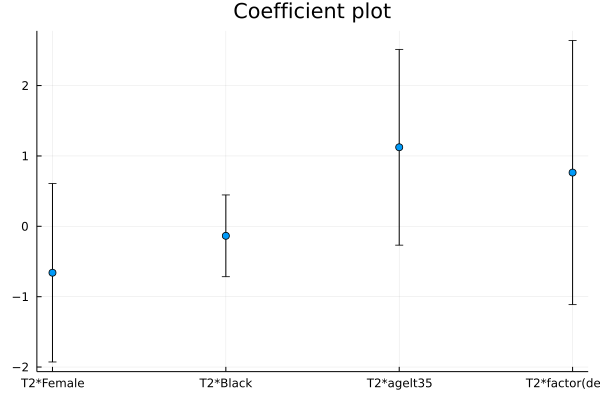

In [33]:
Plots.scatter(labels, coeff, legend = false, yerror = 1.96 .* std, title = "Coefficient plot")


## <span style="color:blue">Py Notebook Vaccine RCTs</span>

### Polio RCT

One of the earliest randomized experiments were the Polio vaccination trias conducted by the Public Health Service in 1954. The question was whether Salk vaccine prevented polio. Children in the study were randomly assigned either a treatment (polio vaccine shot) or a placebo (saline solution shot), without knowing which one they received. The doctors in the study, making the diagnosis, did not know whether a child received a vaccine or not. In other words, the trial was a double-blind, randomized control trial. The trial had to be large, because the rate at which Polio occured in the population was 50 per 100,000. The treatment group saw 33 polio cases per 200,745; the control group saw 115 cases per 201,229. The estimated avearage treatment effect is about

$$-40$$

with the 95% confidence band (based on approximate normality of the two sample means and their differences):

$$[−52,−28]$$
 
As this is an RCT, the confidence band suggests that the Polio vaccine caused the reduction in the risk of polio.

The interesting thing here is that we don't need the underlying individual data to evaluate the effectivess of the vaccine. This is because the outcomes are Bernoulli random variables, and we have enough information to compute the estimate of ATE as well as the confidence intervals from the group case counts.

We also compute the Vaccine Efficacy metric, which refers to the following measure according to the CDC:

$$VE=\frac{Risk for Unvaccinated - Risk for Vaccinated}{Risk for Unvaccinated}$$
 
It describes the relative reduction in risk caused by vaccination.

It is staighforward to get the VE estimate by just plugging-in the numbers, but how do we get the approximate variance estimate? I am too lazy to do calculations for the delta method, so I will just use a simulation (a form of approximate bootstrap) to obtain the confidence intervals.

In [34]:
NT = 200745 #number of treated
NC = 201229 #number of controlled
YT = 33/NT  #average outcome for treated
YC =115/NC  #average outcome for controlled

0.0005714882049803955

In [35]:
print("Incidence per 100000 among treated: ", (YT*100000))

Incidence per 100000 among treated: 16.438765598146905

In [36]:
print( "Incidence per 100000 among controlled: ", (YC*100000))

Incidence per 100000 among controlled: 57.14882049803955

In [37]:
# treatment effect estimate reduction in incidence  per 100000 people
delta_hat = 100000*(YT-YC)
print("Estimate TE of occurances per 100,000 ", 100000*(YT-YC))

Estimate TE of occurances per 100,000 -40.71005489989265

In [38]:
# standard deviation
Var_delta_hat =  (100000^2)*(YT*(1-YT)/NT +  YC*(1-YC)/NC)
print("Standard deviation for ATE: ", Var_delta_hat^0.5)

Standard deviation for ATE: 6.047412320702958

In [39]:
# here we are using the fact that outcomes are Bernoulli 
CI_delta = [delta_hat-1.96*Var_delta_hat^0.5,delta_hat+1.96*Var_delta_hat^0.5]
print("95 % confidence interval is [", (CI_delta[1]), ",", CI_delta[2], "]")

95 % confidence interval is [-52.56298304847044,-28.85712675131485]

In [40]:
# Here we calculate the overall effectiveness of the vaccine and construct confidence intervals for it
NV =  200745
NU =  201229
RV = 33/NV
RU = 115/NU
VE = (RU - RV)/RU
print("Overall VE is ", VE)
# this recovers the number in the table.

Overall VE is 0.7123516206478694

In [41]:
# we set up a simulation example.
# calulate variance of risk estimates:
Var_RV = RV*(1-RV)/NV
Var_RU = RU*(1-RU)/NU

2.8383662703286493e-9

In [42]:
# set-up MC draws:
B = 10000
RVs = RV.+randn(B)*(Var_RV)^0.5
RUs = RU.+randn(B)*(Var_RU)^0.5
VEs= (RUs.-RVs)./RUs

10000-element Vector{Float64}:
 0.7913751097494636
 0.6603896515433899
 0.7108990243306428
 0.700525724750176
 0.7551457381618992
 0.7923194576369001
 0.6936093206817264
 0.6781336753697997
 0.6870223532204311
 0.6859571082770276
 0.7041743576307808
 0.6446301249502728
 0.6791896519791887
 ⋮
 0.7202944148708252
 0.6783263988821183
 0.710697242270746
 0.623470595829958
 0.6358856647422944
 0.7955397313603961
 0.711630177653067
 0.7677991579784805
 0.6759448547329707
 0.7331175547752001
 0.7583568941082665
 0.757197231653064

In [43]:
CI_VE_L = quantile!(VEs, .025)
CI_VE_U = quantile!(VEs, .975)

print("95 % confidence interval is [",CI_VE_L,",",CI_VE_U,"]")

95 % confidence interval is [0.5897208807977812,0.8144993857906673]

In [45]:
y = kde(VEs,npoints=10000,bandwidth=0.02)
PlotlyJS.Plot(y.x,y.density)

data: [
  "scatter with fields type, x, and y"
]

layout: "layout with fields margin and template"

## Pfizer/BNTX Covid-19 RCT

Pfizer/BNTX was the first vaccine approved for emergency use to reduce the risk of Covid-19 decease. In studies to assess vaccine efficacy, volunteers were randomly assigned to receive either a treatment (2-dose vaccination) or a placebo, without knowing which they recieved. The doctors making the diagnoses did not know now whether a given volunteer received a vaccination or not. The results of the study are given in the following table.

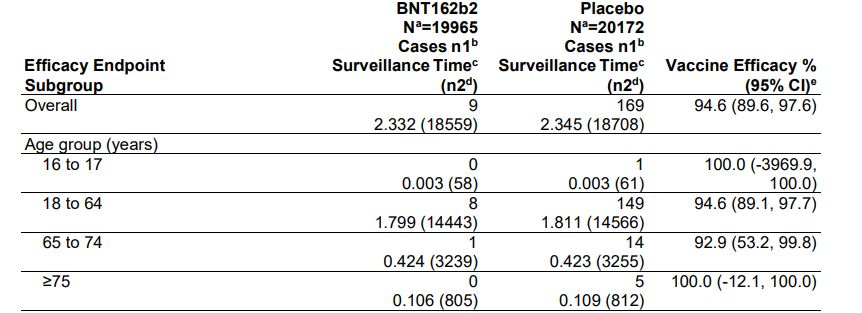

In [46]:
img_path = "table 8.jpg"
img = load(img_path)

Here we see both the overall effects and the effects by age group. The confidence intervals for the averal ATE are tight and suggest high effectiveness of the vaccine. The confidence intervals for the age group 65-75 are much wider. We could group 65-75 and >75 groups to evaluate the effectiveness of the vaccine and also narrow down the width of the confidence band.

In this case, the reported results are for vaccine effectiveness. We use the same approach as above.

In the code cell below we calculate the overall effectiveness of the vaccie and construct confidence intervals for it.

In [47]:
NV =  19965;
NU =  20172;
RV = 9/NV;
RU = 169/NU;
VE = (RU - RV)/RU;

print("Overall VE is ", VE)


Overall VE is 0.9461934124362605

In [48]:
# this recovers the number in the table.

# we set up a simulation example.

# calulate variance of risk estimates:


Var_RV = RV*(1-RV)/NV
Var_RU = RU*(1-RU)/NU

# set-up MC draws:

B = 10000
RVs = RV  .+ randn(B)*(Var_RV)^0.5
RUs = RU  .+ randn(B)*(Var_RU)^0.5
VEs= (RUs .- RVs)./RUs

CI_VE_L = quantile!(VEs, .025)
CI_VE_U = quantile!(VEs, .975)

print("95 % confidence interval is [", CI_VE_L, ",", CI_VE_U, "]")

95 % confidence interval is [0.9090331526482937,0.9812295620999917]

In [49]:
y = kde(VEs,npoints=10000,bandwidth=0.02)
PlotlyJS.Plot(y.x,y.density)

data: [
  "scatter with fields type, x, and y"
]

layout: "layout with fields margin and template"

In the code cell below we calculate the effectiveness of the vaccine for the two groups that are 65 or older

In [50]:
# Here we calculate the overall effectiveness of the vaccine for the two groups that are 65 or older

NV =  3239+805;
NU =  3255+812;
RV = 1/NV;
RU = (14+5)/NU;
VE = (RU - RV)/RU;

print("Overall VE is ",VE)

Overall VE is 0.9470690822010516

In [51]:
# this recovers the number in the table.

# we set up a simulation example.

# calulate variance of risk estimates:


Var_RV = RV*(1-RV)/NV
Var_RU = RU*(1-RU)/NU

# set-up MC draws:

B = 10000
RVs = RV  .+ randn(B)*(Var_RV)^0.5
RUs = RU  .+ randn(B)*(Var_RU)^0.5
VEs= (RUs .- RVs)./RUs


CI_VE_L = quantile!(VEs, .025)
CI_VE_U = quantile!(VEs, .975)

print("95 % confidence interval is [",CI_VE_L, ",", CI_VE_U, "]")

95 % confidence interval is [0.8121077985280102,1.0536674209761563]

In [52]:
CI_VE_L = quantile!(VEs, .05)

print("95 % confidence interval is [", CI_VE_L, ",", 1, "]")

95 % confidence interval is [0.8409603027946478,1]

In [53]:
y = kde(VEs,npoints=10000,bandwidth=0.02)
PlotlyJS.Plot(y.x,y.density)

data: [
  "scatter with fields type, x, and y"
]

layout: "layout with fields margin and template"

In [54]:
NV =  3239+805;
NU =  3255+812;
RV = 1/NV;
RU = (14+5)/NU;
VE = (RU - RV)/RU;

print("Overall VE is ", VE)

Overall VE is 0.9470690822010516

In [55]:
using Distributions

In [56]:
B = 10000 #number of simulation draw

RVs = Binomial(NV, RV)
RVs = rand(RVs,B)
RUs = Binomial(NU,RU)
RUs = rand(RUs,B)

VEs= (RUs .- RVs)./RUs


CI_VE_L = quantile!(VEs, .025)
CI_VE_U = quantile!(VEs, .975)

print("95 % confidence interval is [",CI_VE_L, ",", CI_VE_U, "]")

95 % confidence interval is [0.8,1.0]

In [57]:
CI_VE_L = quantile!(VEs, .05)


print("95 % confidence interval is [", CI_VE_L, ",", 1, "]")

95 % confidence interval is [0.8333333333333334,1]

In [58]:
y = kde(VEs,npoints=10000,bandwidth=0.02)
PlotlyJS.Plot(y.x,y.density)

data: [
  "scatter with fields type, x, and y"
]

layout: "layout with fields margin and template"

## <span style="color:blue">R Notebook Some RCT Examples</span>.


Polio RCT
One of the earliest randomized experiments were the Polio vaccination trials conducted by the Public Health Service in 1954. The question was whether Salk vaccine prevented polio. Children in the study were randomly assigned either a treatment (polio vaccine shot) or a placebo (saline solution shot), without knowing which one they received. The doctors in the study, making the diagnosis, did not know whether a child received a vaccine or not. In other words, the trial was a double-blind, randomized control trial. The trial had to be large, because the rate at which Polio occured in the population was 50 per 100,000. The treatment group saw 33 polio cases per 200,745; the control group saw 115 cases per 201,229. The estimated avearage treatment effect is about

$$-40$$
 
with the 95% confidence band (based on approximate normality of the two sample means and their differences):

$$[
−
52
,
−
28
]$$

 
As this is an RCT, the confidence band suggests that the Polio vaccine **caused** the reduction in the risk of polio.

The interesting thing here is that we don't need the underlying individual data to evaluate the effectivess of the vaccine. This is because the outcomes are Bernoulli random variables, and we have enough information to compute the estimate of ATE as well as the confidence intervals from the group case counts.

We also compute the Vaccine Efficacy metric, which refers to the following measure according to the CDC:


$$VE  = \frac{Risk for Unvaccinated - Risk for Vaccinated}{Risk for Unvaccinated}$$
 
 
It describes the relative reduction in risk caused by vaccination.

It is staightforward to get the VE estimate by just plugging-in the numbers, but how do we get the approximate variance estimate? I am too lazy to do calculations for the delta method, so I will just use a simulation (a form of approximate bootstrap) to obtain the confidence intervals.

In [59]:
NV = 200745 # number of vaccinated (treated)
NU = 201229 # number of unvaccinated (control)
RV= 33/NV  # average outcome for vaccinated
RU =115/NU  # average outcome for unvaccinated
VE = (RU - RV)/RU; # vaccine efficacy

# incidence per 100000 

print("Incidence per 100000 among treated: ",(RV*1000000))

Incidence per 100000 among treated: 164.38765598146904

In [60]:
print("Incidence per 100000 among controlled: ", (RU*1000000))

Incidence per 100000 among controlled: 571.4882049803955

In [61]:
# treatment effect - estimated reduction in incidence per 100000 people
delta_hat = 100000*(RV-RU)

print("Estimated ATE of occurances per 100,000 is ", delta_hat)

Estimated ATE of occurances per 100,000 is -40.71005489989265

In [62]:
# variance, standard deviation and confidence interval of ATE using that outcomes are Bernoulli
Var_RV = RV*(1-RV)/NV
Var_RU = RU*(1-RU)/NU
Var_delta_hat =  100000^2*(Var_RV + Var_RU)
Std_delta_hat = sqrt(Var_delta_hat)

print("Standard deviation for ATE is ", Std_delta_hat)

Standard deviation for ATE is 6.047412320702958

In [63]:
CI_delta = (delta_hat -1.96*sqrt(Var_delta_hat), 
             delta_hat +1.96*sqrt(Var_delta_hat))

print("95% confidence interval of ATE is [",CI_delta[1], ",", 
            CI_delta[2], "]"   )

95% confidence interval of ATE is [-52.56298304847044,-28.85712675131485]

In [64]:
print("Overall VE is ",VE)

Overall VE is 0.7123516206478694

In [65]:
# we use an approximate bootstrap to find the confidence interval of vaccine efficacy
# via Monte Carlo draws

Random.seed!(23)
B = 10000 # number of bootstraps
RVs = RV  .+ randn(B)*(Var_RV)^0.5
RUs = RU  .+ randn(B)*Var_RU^0.5
VEs= (RUs .- RVs)./RUs

10000-element Vector{Float64}:
 0.6969802582849306
 0.7523050181013088
 0.7028285795290898
 0.6369399002688011
 0.732328090217702
 0.6934493191392137
 0.800566974356277
 0.6642771416472922
 0.7386716605462593
 0.6146286493076323
 0.6441826929724741
 0.7869182494610717
 0.7467932338241092
 ⋮
 0.7494105284247187
 0.6531026980118518
 0.7543439813934746
 0.7118288307122183
 0.7143759292334262
 0.7351299326548295
 0.6687720248872808
 0.7425395230070695
 0.6577036082925881
 0.6344521618482275
 0.6893920889733567
 0.7004521068057475

In [66]:
y = kde(VEs,npoints=10000,bandwidth=0.008257)
PlotlyJS.Plot(y.x,y.density)

data: [
  "scatter with fields type, x, and y"
]

layout: "layout with fields margin and template"

## Pfizer/BNTX Covid-19 RCT

Pfizer/BNTX was the first vaccine approved for emergency use to reduce the risk of Covid-19 decease. In studies to assess vaccine efficacy, volunteers were randomly assigned to receive either a treatment (2-dose vaccination) or a placebo, without knowing which they recieved. The doctors making the diagnoses did not know now whether a given volunteer received a vaccination or not. The results of the study are given in the following table.



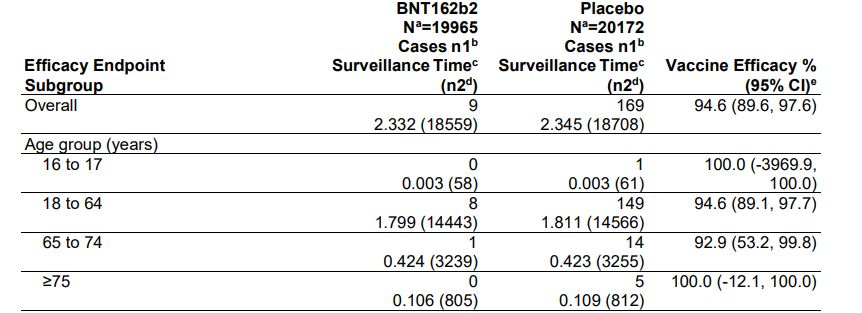

In [67]:
# specify the path to your local image file
img_path = "table 8.jpg"
img = load(img_path)

Here we see both the overall effects and the effects by age group. The confidence intervals for the overall ATE are tight and suggest high effectiveness of the vaccine. The confidence intervals for the age group 65-75 are much wider due to the relatively small number of people in this group. We could group 65-75 and >75 groups to evaluate the effectiveness of the vaccine for this broader age group and narrow the width of the confidence band.

We use the same approach as that for the Polio example. This gives slightly different results than the FDA result, because the FDA used inversion of exact binomial tests to construct confidence intervals. We use asymptotic approches based on approximate normality, which is more crude, but delivers a rather similar result.

In [68]:
NV =  19965; # number vaccinated
NU =  20172; # number unvaccinated
RV = 9/NV; # average outcome for vaccinated
RU = 169/NU; # average outcome for unvaccinated
VE = (RU - RV)/RU; # vaccine efficacy

# incidence per 100000
Incidence_RV=RV*100000
Incidence_RU=RU*100000

print("Incidence per 100000 among vaccinated: ", Incidence_RV)

Incidence per 100000 among vaccinated: 45.07888805409467

In [69]:
print("Incidence per 100000 among unvaccinated: ",Incidence_RU)

Incidence per 100000 among unvaccinated: 837.7949633154868

In [70]:
# treatment effect - estimated reduction in incidence per 100000 people
delta_hat = 100000*(RV-RU)
      
print("Estimated ATE of occurances per 100,000 is ", delta_hat)

Estimated ATE of occurances per 100,000 is -792.7160752613921

In [71]:
# variance, standard deviation and confidence interval of ATE using that outcomes are Bernoulli
Var_RV = RV*(1-RV)/NV
Var_RU = RU*(1-RU)/NU
Var_delta_hat =  100000^2*(Var_RV + Var_RU)
Std_delta_hat = Var_delta_hat^0.5

print("Standard deviation for ATE is ", Std_delta_hat)

Standard deviation for ATE is 65.91015718590171

In [72]:
CI_delta = (delta_hat -1.96*sqrt(Var_delta_hat), 
             delta_hat +1.96*sqrt(Var_delta_hat))

print("95% confidence interval of ATE is [", CI_delta[1], ",", 
            CI_delta[2], "]"   )

95% confidence interval of ATE is [-921.8999833457594,-663.5321671770248]

In [73]:
print("Overall VE is ", VE)

Overall VE is 0.9461934124362605

In [74]:
# we use an approximate bootstrap to find the VE confidence interval
# using Monte Carlo draws as before
Random.seed!(1)
B = 10000
RVs = RV  .+ randn(B)*sqrt(Var_RV)
RUs = RU  .+ randn(B)*sqrt(Var_RU)
VEs= (RUs .- RVs)./RUs

10000-element Vector{Float64}:
 0.9442933870001476
 0.9443520308080368
 0.9533271463242593
 0.9431114159885612
 0.9659201073606357
 0.9434698262857963
 0.9010208756432786
 0.9472785099316176
 0.9454260735333324
 0.9877207122375878
 0.9370048278986588
 0.9413689751100011
 0.9346442262928903
 ⋮
 0.9431160740141705
 0.9484165204161595
 0.9394278574908207
 0.941157001243985
 0.9561737195938147
 0.9207834200749482
 0.9446717480907362
 0.9463925959237801
 0.9120337712819295
 0.9508383971988779
 0.936984927244311
 0.9539275902208578

In [75]:
y = kde(VEs,npoints=10000,bandwidth=0.002677)
PlotlyJS.Plot(y.x,y.density)

data: [
  "scatter with fields type, x, and y"
]

layout: "layout with fields margin and template"

In [76]:
CI_VE_L = quantile!(VEs, .025)
CI_VE_U = quantile!(VEs, .975)

print("95 % confidence interval is [",CI_VE_L,",",CI_VE_U,"]")

95 % confidence interval is [0.9081360866032631,0.981397031636626]

In the code cell below we calculate the effectiveness of the vaccine for the two groups that are 65 or older

In [77]:
# Here we calculate the overall effectiveness of the vaccine for the two groups that are 65 or older
NV =  3239+805;
NU =  3255+812;
RV = 1/NV;
RU = (14+5)/NU;
VE = (RU - RV)/RU;

print("Overall VE is ",VE)

Overall VE is 0.9470690822010516

In [78]:
Var_RV = RV*(1-RV)/NV
Var_RU = RU*(1-RU)/NU

# As before, we use an approximate bootstrap to find the confidence intervals
# using Monte Carlo draws

Random.seed!(15)
B = 10000
    RVs = RV  .+ randn(B)*sqrt(Var_RV) .+ 10^(-10)
    RUs = RU  .+ randn(B)*sqrt(Var_RU) .+ 10^(-10)
    VEs= (RUs .- RVs)./RUs

10000-element Vector{Float64}:
 0.9117409275785884
 0.9223789978101362
 0.9314804351313534
 0.9944555038117479
 0.9466418491362989
 0.922565771595756
 0.9032798245178391
 0.9574060215487704
 1.0232568602881558
 0.9353121786030973
 0.9181853247780436
 0.813209579976601
 0.9531962858488556
 ⋮
 0.9246414168339447
 0.9726997808368567
 0.9286666546227026
 0.9765132165135133
 0.8665295902134885
 0.9216334062776051
 0.9177601175249421
 0.9252282347318473
 0.9623935095331394
 1.0375474751011036
 0.93542417477847
 0.963417432699566

In [79]:
y = kde(VEs,npoints=10000,bandwidth=0.007965)
PlotlyJS.Plot(y.x,y.density)

data: [
  "scatter with fields type, x, and y"
]

layout: "layout with fields margin and template"

In [80]:
CI_VE_L = quantile!(VEs, .025)
CI_VE_U = quantile!(VEs, .975)

print("95 % confidence interval is [",CI_VE_L,",",CI_VE_U,"]")

95 % confidence interval is [0.8107583199993115,1.05472124601583]

In [81]:
CI_VE_L = quantile!(VEs, .05)


print("95 % confidence interval is [", CI_VE_L, ",", 1, "]")

95 % confidence interval is [0.8401781650161627,1]

Let's try the parametric boostrap next, using the fact that the outcome is Bernouli.

In [82]:
NV =  3239+805;
NU =  3255+812;
RV = 1/NV;
RU = (14+5)/NU;
VE = (RU - RV)/RU;

print("Overall VE is ", VE)

Overall VE is 0.9470690822010516

In [83]:
Random.seed!(23)
B = 10000 #number of simulation draw
RVs = Binomial(NV, RV)
RVs = rand(RVs,B)
RUs = Binomial(NU,RU)
RUs = rand(RUs,B)
VEs= (RUs .- RVs)./RUs

10000-element Vector{Float64}:
 0.9523809523809523
 0.9583333333333334
 0.95
 1.0
 0.92
 0.9375
 1.0
 1.0
 1.0
 0.8333333333333334
 0.9333333333333333
 1.0
 1.0
 ⋮
 0.9
 0.9523809523809523
 0.9285714285714286
 0.9375
 0.9411764705882353
 1.0
 0.9444444444444444
 0.9375
 1.0
 1.0
 0.9444444444444444
 1.0

In [84]:
y = kde(VEs,npoints=10000,bandwidth=0.005365)
PlotlyJS.Plot(y.x,y.density)

data: [
  "scatter with fields type, x, and y"
]

layout: "layout with fields margin and template"

In [85]:
CI_VE_L = quantile!(VEs, .025)
CI_VE_U = quantile!(VEs, .975)

print("95 % confidence interval is [",CI_VE_L,",",CI_VE_U,"]")

95 % confidence interval is [0.8,1.0]

In [86]:
CI_VE_L = quantile!(VEs, .05)


print("95 % confidence interval is [", CI_VE_L, ",", 1, "]")

95 % confidence interval is [0.8333333333333334,1]

## Exact Binomial Test Inversion

It is possible to use exact inference by inverting tests based on the exact binomial nature of the outcome variable. Here, we perform the Cornfield Procedure to find the exact confidence interval on the estimate of vaccine efficacy.

In [87]:
NV =  19965;
NU =  20172;
RV = 9/NV;
RU = 169/NU;
VE = (RU - RV)/RU;


confint = orpropci(9::Int, NV::Int, 169::Int, NU::Int; alpha = 0.05)::ConfInt
l=1-0.027616272602670834
u=1-0.10317864685976501
confint = (l,u)

(0.9723837273973291, 0.896821353140235)

Note that this exactly recovers the result in the FDA table (first row).

Next we repeat the cornfield procedure to find the exact confidence interval on vaccine effectiveness for the two groups that are 65 or older. Here we see a big discrepancy between various asymptotic approaches and the exact finite-sample inference. This occurs because the binomial counts are too low for central limit theorems to work successfully.

In [88]:
# Exact CI exploiting Bernoulli outcome for the two groups that are 65 or older
NV =  3239+805;
NU =  3255+812;
RV = 1/NV;
RU = (14+5)/NU;
VE = (RU - RV)/RU;

confint = orpropci(1::Int, NV::Int, 19::Int, NU::Int; alpha = 0.05)::ConfInt
l=1-0.00896277602085047
u=1-0.30983022294266616
confint = (l,u)

(0.9910372239791495, 0.6901697770573338)